# Blackbox Optimization with LIPO

In [3]:
import numpy as np
from numpy.random import uniform
from numpy.linalg import norm
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

## Introduction
Blackbox-optimization is often carried out using an exhaustive exploration over the space of feasible variable configurations or by building a probabilistic model of the object and optimizing a simpler proxy. In the case of grid search, the optimization process often results in a very time consuming operation - while Baysian optimization requires careful setting of the hyperparameters and a well chosen prior to converge to an acceptable result. Often times simple random search preforms comparably to these more sophisticated and technical approaches while being much cheaper! In the recent paper [Global Optimization of Lipschitz Functions](https://arxiv.org/abs/1703.02628), the authors Cedric Malherbe and Nicolas Vayatis propose a simple gradient and parameter-free global optimizer. They examine a very simple algorithm called LIPO to jointly approximate the Lipschitz constant of a function and learn a piecewise linear upperbound based on the approximated constant.

They derive several nice theoretical properties, but the most important one in my opinion is that their algorithm is superior to random search in several cases. They also empirically demonstrate that their algorithm performs comparably to other popular black box optimizers like Baysian Optimization.

In this notebook, we will describe the algorithm and background and illustrate the effectveness of this algorithm on problems like hyperparameter tuning.

## Problem Statement
We are interested in solving
$$
x^* = \arg \min_x f(x)
$$
under the constraints that
* $f$ is a black box for which no closed form is known (nor its gradients)
* $f$ may be expensive to evaluate and the samples are noisless
* $f$ has finite Lipschitz constant $k$ i.e. $$\exists k \geq 0 \text{ s.t. } |f(x) - f(x')| \leq k \cdot ||x - x'||_2 \:\: \forall(x,x') \in \chi^2$$


Assume the following noisy function $f(x) = \sin(5 \cdot x)\cdot \tanh(1 - x^2) + \epsilon$.

By MVT, $|f(x) - f(y)| \leq \sup |f'(x)||x-y|$. Since $\sup |f'(x)| \approx 5$, so $k \approx 5$.


In [0]:
noise_level = 0.1
k = 5

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

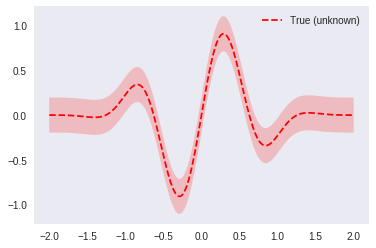

In [47]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In the paper, the authors propose a piecewise linear upper bound to $f$ with $U(x) = min_{i=1,\ldots,t} (f(x_i) + k||x-x_i||_2)$ for $t$ samples of $f$. One can then easily determine new samples to evaluate by finding the maximum of this upper bound.

## LIPO loop

**Input:** $n \in \mathbb{N}^*$, $k \geq 0$, $\chi \subset \mathbb{R}^d$, $f \in Lip(k)$
1.   **Initialization:** Let $X_1 ∼ U(X)$

     Evaluate $f(X_1)$, $t \rightarrow 1$

2.   **Iterate:** Repeat while $t < n$:

      Let $X_1 ∼ U(X)$

      If $\min_{i=1\ldots t}(f(X_i) + k || X_{t+1} - X_i||_2) \geq \max_{i=1\ldots t}f(X_i)$
      
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Evaluate $f(X_{t+1})$, $t \rightarrow t+1$

3.   **Output:** Return $X_{\hat{l}_n}$ where $\hat{l}_n \in \arg \max_{i=1\ldots n}f(X_i)$
     





In [0]:
def lipo(n, k, X, f):
    x_t = np.array([uniform(x[0],x[1]) for x in X])
    f_t = []
    f_t.append((x_t,f(x_t)))
    t = 1
    
    while t < n:
        x_t = np.array([uniform(x[0],x[1]) for x in X])
        if min([f_i[1] + k*norm(x_t - f_i[0]) for f_i in f_t]) >= max(f_t, key = lambda i: i[1])[1]:
            f_t.append((x_t,f(x_t)))
            t = t + 1
    return max(f_t, key = lambda i: i[1])

In [45]:
n = 15
X = [(-2,2)]
print(lipo(n, k, X, f))

(array([-0.27649739]), 0.9374534133471826)


## Estimating $k$
The authors propose a simple way to estimate $k$ in the case that we do not know the Lipschitz constant prior to running the algorithm. To approximate $k$, they solve the following optimization problem for all observed points:
\begin{align}
&\min_{k\in \mathbb{Z}} k \\
&\text{st } \max_{i,j}\frac{|f(X_i) - f(X_j)|}{||X_i - X_j||_2} \leq k
\end{align}

## Adaptive LIPO (AdaLIPO)
To incorporate the $k$ approximation into LIPO, the authors propose an adaptive procedure _Adapive LIPO_ (AdaLIPO) to jointly learn $k$ and optimize the objective $f$. Each iteration, we determine whether to _explore_ or _exploit_ by sampling from a binomial distribution with parameter $p$. In the exploration phase we sample a vector uniformly over the parameter space. In the exploitation phase we sample a vector .

## AdaLIPO loop

**Input:** $n \in \mathbb{N}^*$, $k \geq 0$, $\chi \subset \mathbb{R}^d$, $f \in Lip(k)$
1.   **Initialization:** Let $X_1 ∼ U(X)$

     Evaluate $f(X_1)$, $t \rightarrow 1$

2.   **Iterate:** Repeat while $t < n

      Let $B_{t+1} \sim \mathbb{B}(p)$

      If $B_{t+1} = 1$ (Exploration)
      
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let $X_1 \sim U(X)$

      If $B_{t+1} = 0$ (Exploitation)
      
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let $X_1 \sim U(X_{\hat{k},t})$ where $X_{\hat{k}_t,t}$ denotes the set of potential maximizers computed with $k$ set to $\hat{k}_t$
      
      Evaluate $f(X_{t+1}),t \leftarrow t+1$
      
      Let $\hat{k}_t = \inf\{k_{i \in \mathbb{Z}}:
      max_{i \not = j}\frac{|f(X_i) - f(X_j)|}{||X_i - X_j||_2} \leq k_i\}$

3.   **Output:** Return $X_{\hat{l}_n}$ where $\hat{l}_n \in \arg \max_{i=1\ldots n}f(X_i)$

In [0]:
def adalipo(n, k, X, f):
    x_t = np.array([uniform(x[0],x[1]) for x in X])
    f_t = []
    f_t.append((x_t,f(x_t)))
    t = 1
    
    while t < n:
        x_t = np.array([uniform(x[0],x[1]) for x in X])
        if min([f_i[1] + k*norm(x_t - f_i[0]) for f_i in f_t]) >= max(f_t, key = lambda i: i[1])[1]:
            f_t.append((x_t,f(x_t)))
            t = t + 1
    return max(f_t, key = lambda i: i[1])

In [39]:
n = 15
X = [(-2,2)]
print(adalipo(n, k, X, f))

(array([0.27601493]), 1.0680783191592154)
